<a href="https://colab.research.google.com/github/YoYoYo-ji/tire-error-detection/blob/master/vae_error_det_ano_yuzawa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.layers import BatchNormalization, Activation, Flatten
from keras.layers.convolutional import Conv2DTranspose, Conv2D

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
%matplotlib inline


Using TensorFlow backend.


In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
#ヒートマップの描画
def save_img(x_normal, x_anomaly, img_normal, img_anomaly, name):
    path = 'images/'
    if not os.path.exists(path):
          os.mkdir(path)

    #　※注意　評価したヒートマップを1～10に正規化
    img_max = np.max([img_normal, img_anomaly])
    img_min = np.min([img_normal, img_anomaly])
    img_normal = (img_normal-img_min)/(img_max-img_min) * 9. + 1.
    img_anomaly = (img_anomaly-img_min)/(img_max-img_min) * 9. + 1.
    
    img_normmal = np.log(img_normal)
    img_anomaly = np.log(img_anomaly)
        
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(x_normal[0, :, :, :], cmap='gray')
    plt.axis('off')
    #plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.imshow(img_normal[0, :, :, :], cmap='Blues')#,norm=colors.LogNorm())
    plt.axis('off')
    #plt.colorbar()
    #plt.clim(1, 10)

    plt.title(name + "normal")

    plt.subplot(2, 2, 3)
    plt.imshow(x_anomaly[0, :, :, :], cmap='gray')
    plt.axis('off')
    #plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(img_anomaly[0, :, :, :], cmap='Blues')#,norm=colors.LogNorm())
    plt.axis('off')
    #plt.colorbar()
    #plt.clim(1, 10)

    plt.title(name + "anomaly")

    plt.savefig(path + name +".png")
    plt.show()
    plt.close()

In [0]:
#ヒートマップの計算
def evaluate_img(model, x_normal, x_anomaly, name, height=32, width=32, move=2):
    img_normal = np.zeros((x_normal.shape))
    img_anomaly = np.zeros((x_normal.shape))

    '''この場合のヒートマップの計算方法
    画像の各ピクセルを走査していき、それをx_sub_??????に代入していく。
    そこに代入された値を学習させた深層学習モデルに入れていき、画像を再構築、そして、それを元に異常度を提案手法（loss functionを異常度に合わせて変えていく）・従来手法（復元されたものの値をそのまま異常度として採用）の２つで計算していく。
    '''
    for i in range(int((x_normal.shape[1] - height) / move)):
        for j in range(int((x_normal.shape[2] - width) / move)):
            x_sub_normal = x_normal[0, i * move : i * move + height, j * move : j * move + width, :]
            x_sub_anomaly = x_anomaly[0, i * move : i * move + height, j * move : j * move + width, :]
            x_sub_normal = x_sub_normal.reshape(1, height, width, 3)
            x_sub_anomaly = x_sub_anomaly.reshape(1, height, width, 3)
            
            x_sub_normal = np.mean(x_sub_normal, axis=0)
            x_sub_anomaly = np.mean(x_sub_anomaly, axis=0)

            #従来手法
            if name == "old_":
                #正常のスコア
                normal_score = model.evaluate(x_sub_normal, batch_size=1, verbose=0)
                img_normal[0, i*move:i*move+height, j*move:j*move+width, 0] +=  normal_score

                #異常のスコア
                anomaly_score = model.evaluate(x_sub_anomaly, batch_size=1, verbose=0)
                img_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0] +=  anomaly_score

            #提案手法　（本来はスライスの最後の部分は[0, k, l, 0] ->[0, k, l, :]）
            else:
                #正常のスコア
                mu, sigma = model.predict(x_sub_normal, batch_size=1, verbose=0)
                loss = 0
                for k in range(height):
                    for l in range(width):
                        loss += 0.5 * (x_sub_normal[0 ,k ,l ,:] - mu[0 ,k ,l ,:]) ** 2 / sigma[0 ,k ,l ,:]
                img_normal[0, i * move : i * move + height, j * move : j * move + width, 0] +=  loss

                #異常のスコア
                mu, sigma = model.predict(x_sub_anomaly, batch_size=1, verbose=0)
                loss = 0
                for k in range(height):
                    for l in range(width):
                        loss += 0.5 * (x_sub_anomaly[0, k, l, :] - mu[0, k, l, :]) ** 2 / sigma[0, k, l, :]
                img_anomaly[0, i * move : i * move + height, j * move : j * move + width, :] +=  loss

    save_img(x_normal, x_anomaly, img_normal, img_anomaly, name)

---------------
[1 1 1 ... 1 1 1]
---------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 16, 16, 32)   128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 8, 8, 64)     18496       batch_normalization_13[0][0]     
___________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


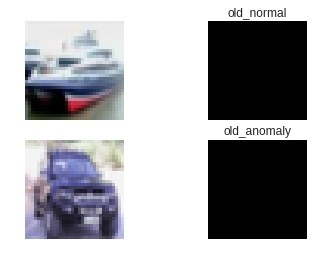

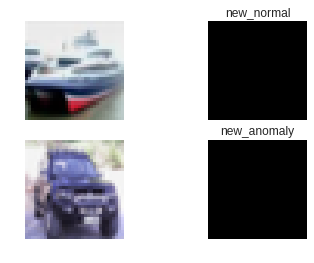

In [9]:
# cifar-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

image_size = x_train.shape[1]

x_train = np.reshape(x_train, [-1, image_size, image_size, 3])
x_test = np.reshape(x_test, [-1, image_size, image_size, 3])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#データセットから学習させたいクラスのデータを取り出す部分
#set index for class 1 for train datasets
train_idx1 = y_train[np.where(y_train == 1)]

#set index for class 5&9 for test datasets
test_idx1 = y_test[np.where(y_test == 1)]
test_idx9 = y_test[np.where(y_test == 9)]

print("-" * 15)
print(train_idx1)
print("-" * 15)
x_train1 = x_train[train_idx1]
x_test1 = x_test[test_idx1]
x_test9 = x_test[test_idx9]


'''
#異常検知のウェブサイトで使用していたモデル
# network parameters
input_shape = (image_size, image_size, 3)
batch_size = 128
latent_dim = 2
epochs = 10
Nc = 16

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(Nc, kernel_size=2, strides=2)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(2*Nc, kernel_size=2, strides=2)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
#encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(2*2)(latent_inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape((2,2,1))(x)
x = Conv2DTranspose(2*Nc, kernel_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2DTranspose(Nc, kernel_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x1 = Conv2DTranspose(1, kernel_size=4, padding='same')(x)
x1 = BatchNormalization()(x1)
out1 = Activation('sigmoid')(x1)#out.shape=(n,8,8,1)

x2 = Conv2DTranspose(1, kernel_size=4, padding='same')(x)
x2 = BatchNormalization()(x2)
out2 = Activation('sigmoid')(x2)#out.shape=(n,8,8,1)

decoder = Model(latent_inputs, [out1, out2], name='decoder')
'''

#VAEのサンプルから自作したモデル
# network parameters
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 20

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(3):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    
    x = BatchNormalization()(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(3):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2
    
    x = BatchNormalization()(x)

outputs1 = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output1')(x)

outputs2 = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output2')(x)

# instantiate decoder model
decoder = Model(latent_inputs, [outputs1, outputs2], name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs_mu, outputs_sigma = decoder(encoder(inputs)[2])
vae = Model(inputs, [outputs_mu, outputs_sigma], name='vae')

if __name__ == '__main__':
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    '''
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))

    reconstruction_loss *= image_size * image_size
    '''
    m_vae_loss = (K.flatten(inputs) - K.flatten(outputs_mu))**2 / K.flatten(outputs_sigma)
    m_vae_loss = 0.5 * K.sum(m_vae_loss)

    a_vae_loss = K.log(2 * 3.14 * K.flatten(outputs_sigma))
    a_vae_loss = 0.5 * K.sum(a_vae_loss)
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    #Normal VAE model uses loss function below
    #vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    #In this case we adopt this loss function
    vae_loss = K.mean(kl_loss + m_vae_loss + a_vae_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

    # train the autoencoder
    vae.fit(x_train1,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test1, None))
    vae.save_weights('vae_cnn_cifar10_error_detecion.h5')

    #plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

    
    #正常/異常のテストデータ
    idx1 = np.random.randint(len(x_test1))
    idx9 = np.random.randint(len(x_test9))

    test_normal = x_test1[idx1, :, :, :]
    test_anomaly = x_test9[idx9, :, :, :]
    test_normal = test_normal.reshape(1, test_normal.shape[0], test_normal.shape[1], test_normal.shape[2])
    test_anomaly = test_anomaly.reshape(test_normal.shape)

    #従来手法の可視化
    evaluate_img(model=vae, x_normal=test_normal, x_anomaly=test_anomaly, name="old_")

    #提案手法の可視化
    evaluate_img(model=vae, x_normal=test_normal, x_anomaly=test_anomaly, name="new_")


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

upload_file_2 = drive.CreateFile()
upload_file_2.SetContentFile("vae_cnn.png")
upload_file_2.Upload()